# P4 - Advanced Lane Line Finding Project

Import all required packages

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

import camera_calibrate
import undistort
import color_grad_threshold
import perspective_transform
import lanes_overlay

%matplotlib inline

Define helper functions

In [2]:
left_line = None
right_line = None

def show_image(org, org_title, updated, upd_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(org)
    ax1.set_title(org_title, fontsize=30)
    ax2.imshow(updated, 'gray')
    ax2.set_title(upd_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


def equalize_hist(img):

    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    cv2.waitKey(0)
    return img_output


def normalized(img):
    return np.uint8(255*img/np.max(np.absolute(img)))


def to_RGB(img):
   if img.ndim == 2:
       img_normalized = normalized(img)
       return np.dstack((img_normalized, img_normalized, img_normalized))
   elif img.ndim == 3:
       return img
   else:
       return None

# Ref: https://carnd-forums.udacity.com/questions/32706990/want-to-create-a-diagnostic-view-into-your-lane-finding-pipeline
def compose_diagScreen(curverad=0, offset=0, mainDiagScreen=None,
                     diag1=None, diag2=None, diag3=None, diag4=None, diag5=None, diag6=None, diag7=None, diag8=None, diag9=None):
      # middle panel text example
      # using cv2 for drawing text in diagnostic pipeline.
      font = cv2.FONT_HERSHEY_COMPLEX
      middlepanel = np.zeros((240, 640, 3), dtype=np.uint8)
      l1 = np.zeros((50, 50, 3), dtype=np.uint8)
      l2 = np.zeros((50, 50, 3), dtype=np.uint8)
      l3 = np.zeros((50, 50, 3), dtype=np.uint8)
      l4 = np.zeros((50, 50, 3), dtype=np.uint8)

      cv2.putText(middlepanel, '1. Original image', (30, 60), font, 1, (255,0,0), 2)
      cv2.putText(middlepanel, '2. Gradient/Color thresholded', (30, 100), font, 1, (255,0,0), 2)
      cv2.putText(middlepanel, '3. Region selected', (30, 140), font, 1, (255,0,0), 2)
      cv2.putText(middlepanel, '4. Perspective transformed', (30, 180), font, 1, (255,0,0), 2)

      # assemble the screen example
      diagScreen = np.zeros((720, 1920, 3), dtype=np.uint8)
      if mainDiagScreen is not None:
            diagScreen[0:720, 0:1280] = mainDiagScreen
      if diag1 is not None:
            diagScreen[0:240, 1280:1600] = cv2.resize(to_RGB(diag1), (320,240), interpolation=cv2.INTER_AREA) 
            diagScreen[0:50, 1280:1330] = cv2.putText(l1,"1", (15, 35), font, 1, (255,255,0), 2)
      if diag2 is not None:
            diagScreen[0:240, 1600:1920] = cv2.resize(to_RGB(diag2), (320,240), interpolation=cv2.INTER_AREA)
            diagScreen[0:50, 1600:1650] = cv2.putText(l2,"2", (15, 35), font, 1, (255,255,0), 2)
      if diag3 is not None:
            diagScreen[240:480, 1280:1600] = cv2.resize(to_RGB(diag3), (320,240), interpolation=cv2.INTER_AREA)
            diagScreen[240:290, 1280:1330] = cv2.putText(l3,"3", (15, 35), font, 1, (255,255,0), 2)
      if diag4 is not None:
            diagScreen[240:480, 1600:1920] = cv2.resize(to_RGB(diag4), (320,240), interpolation=cv2.INTER_AREA)*4
            diagScreen[240:290, 1600:1650] = cv2.putText(l4,"4", (15, 35), font, 1, (255,255,0), 2)
      diagScreen[480:720, 1280:1920] = middlepanel

      return diagScreen


Define Line class. Instances of this class are used for storing attributes of left / right lines

In [3]:
class Line():
    NX = 8              # the number of inside corners in x
    NY = 6              # the number of inside corners in y
    MTX = None
    DIST = None
    FIRST_FRAME = True
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = [True,True,True,True]  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        self.lastnx = []
        #average x values of the fitted line over the last n iterations
        self.prevx = None
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.lastn_fit = []
        # best fit computed considering average and current fit
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


**Camera Calibration**

*1. Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?*

In [4]:
stat = camera_calibrate.calibrate()
print("Camera is calibrated")


Camera is calibrated


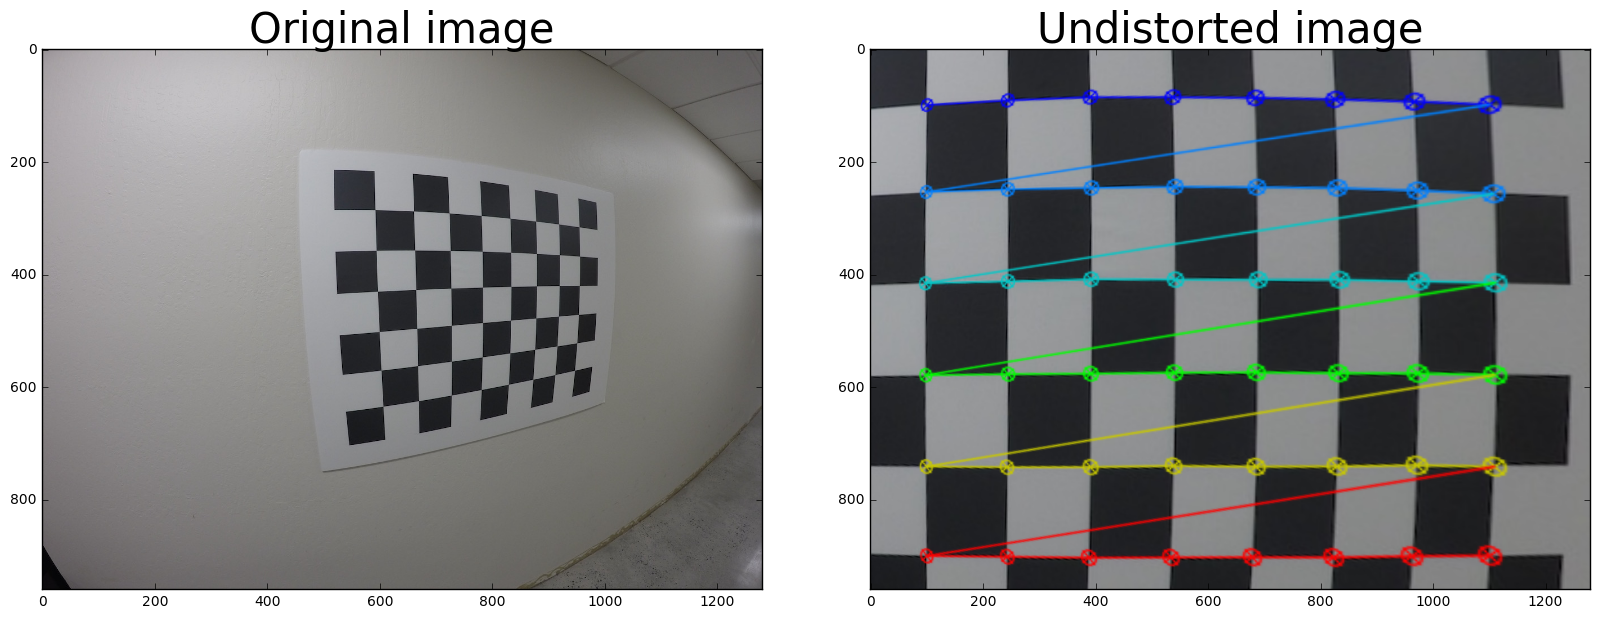

In [5]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "output_images/calibrated_params.p", "rb" ))
Line.MTX = dist_pickle["mtx"]
Line.DIST = dist_pickle["dist"]

# Read in an image
checker_img = mpimg.imread('test_images/checker_test.jpg')

undst_checker, perspective_M = camera_calibrate.calibration_check(checker_img, Line.NX, Line.NY, Line.MTX, Line.DIST)

show_image(checker_img, "Original image", undst_checker, "Undistorted image")


Uncomment one of the images below. This image will be processed in steps below to,
1. Apply distortion correction
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image - used for detecting perspectively transformed shapes.

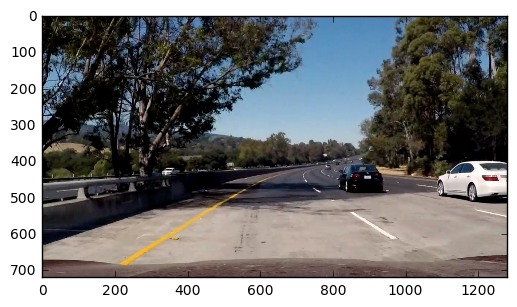

In [7]:
#img = mpimg.imread('test_images/test6.jpg')
#img = mpimg.imread('test_images/test1.jpg')
img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test11.jpg')
#img = mpimg.imread('test_images/test12.jpg')
#img = mpimg.imread('test_images/test13.jpg')
#img = mpimg.imread('test_images/test14.jpg')
#img = mpimg.imread('test_images/test15.jpg')
#img = mpimg.imread('test_images/test16.jpg')
#img = mpimg.imread('test_images/test17.jpg')
#img = mpimg.imread('test_images/test18.jpg')
#img = mpimg.imread('test_images/test19.jpg')

plt.imshow(img)


**Distortion Correction**

*2. Has the distortion correction been correctly applied to each image?*

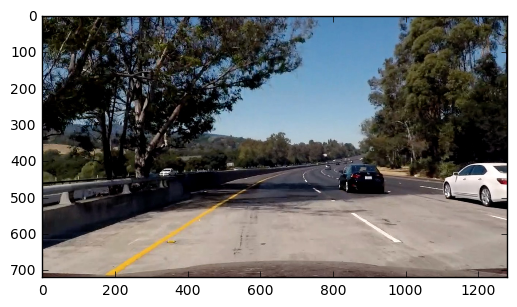

In [8]:
# Instantiate lines
left_line = Line()
right_line = Line()

undst = undistort.perform(img, Line.NX, Line.NY, Line.MTX, Line.DIST)

plt.imshow(undst)


**Thresholded binary image**

*3. Has a binary image been created using color transforms, gradients or other methods?*

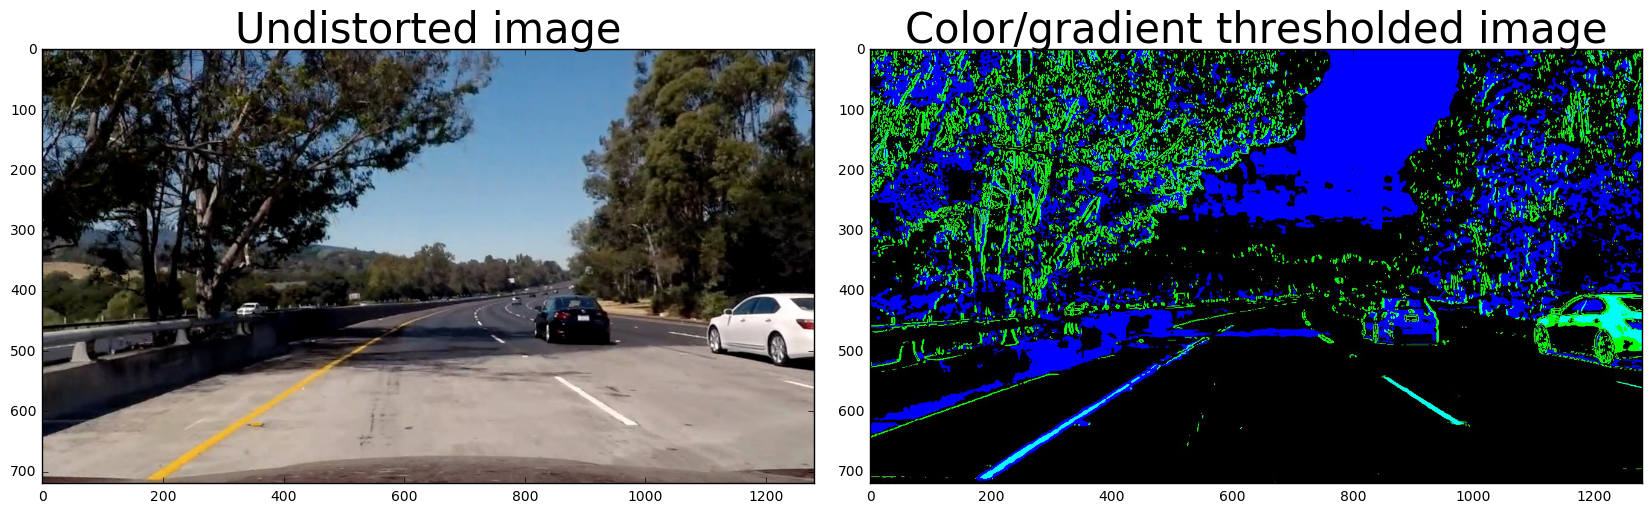

In [9]:
# . ------------------- Color / Gradient Threshold ------------------------
grad_color = color_grad_threshold.perform(undst)
mpimg.imsave('output_images/grad_color.jpg',grad_color)
grad_color = mpimg.imread('output_images/grad_color.jpg')

show_image(undst, "Undistorted image", grad_color, "Color/gradient thresholded image")


**Perspective transform**

*4. Has a perspective transform been applied to rectify the image?*

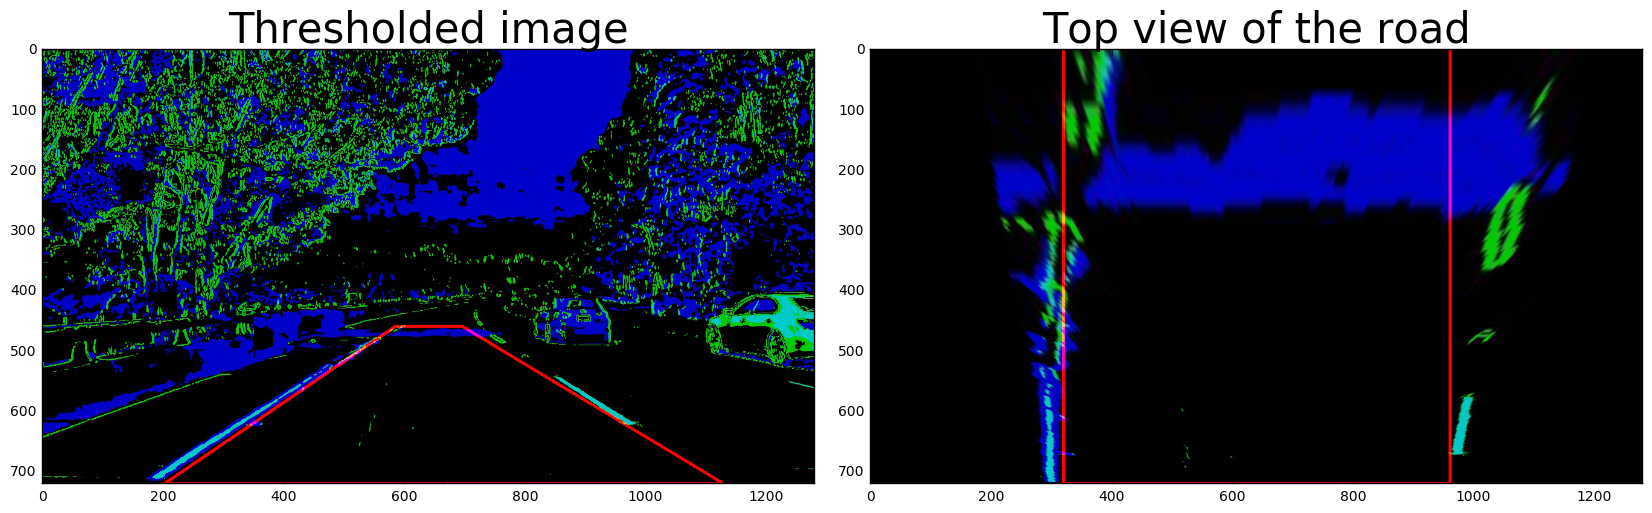

In [10]:
# . ------------------- Perspective Transform -----------------------------
pt_params = perspective_transform.perform(grad_color)

region_select = pt_params["region_select"]
binary_warp = pt_params["binary_warp"]
#M = pt_params["M"]
#binary_unwarp = pt_params["binary_unwarp"]
Minv = pt_params["Minv"]
img_lane = pt_params["img_lane"]
binary_warped_lane = pt_params["binary_warped_lane"]

show_image(img_lane, "Thresholded image", binary_warped_lane, "Top view of the road")


**Polynomial fit**

*5. Have lane line pixels been identified in the rectified image and fit with a polynomial?*

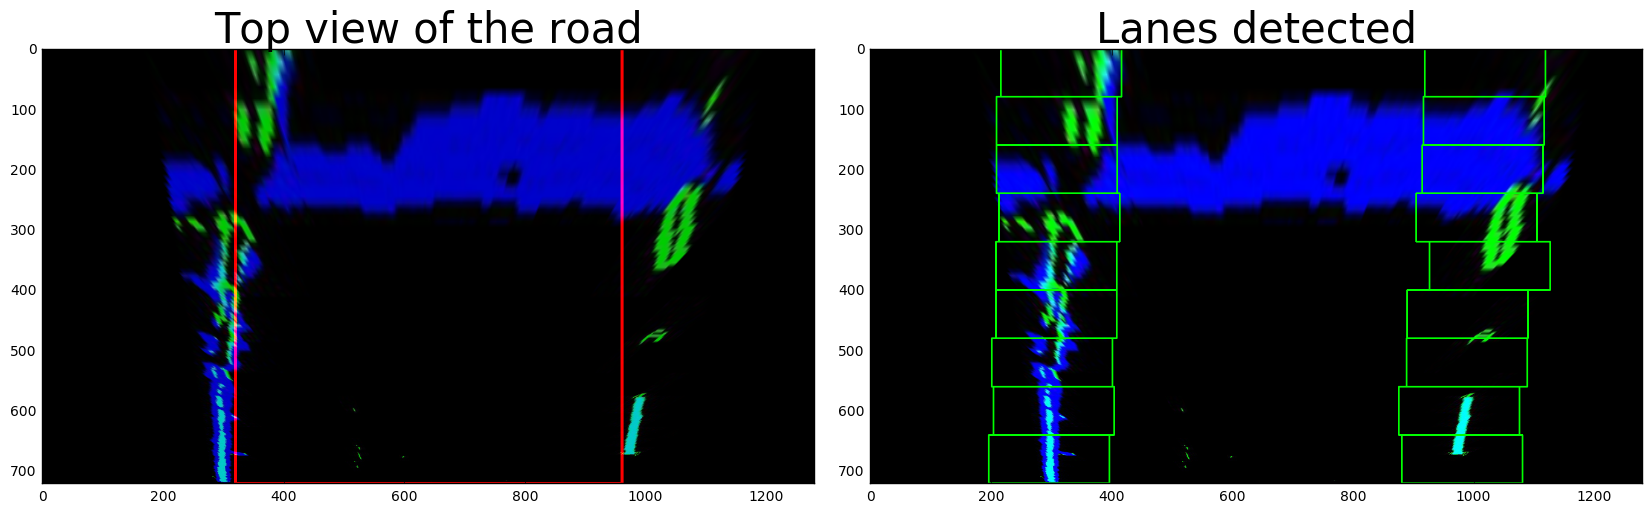

In [11]:
# . ------------------- Detect Lane Lines:Initial test6.jpg ---------------
if Line.FIRST_FRAME:
    out_img,left_line,right_line = lanes_overlay.fit_line_init(binary_warp,left_line,right_line)
    Line.FIRST_FRAME = False
else:
    out_img,left_line,right_line = lanes_overlay.fit_increment(binary_warp,left_line,right_line)

show_image(binary_warped_lane, "Top view of the road", out_img, "Lanes detected")


Defining a function to create and execute the image pipeline

In [15]:
def process_image(img):
    global left_line, right_line
    
    undst = undistort.perform(img, Line.NX, Line.NY, Line.MTX, Line.DIST)

    #undst = equalize_hist(undst)


    # . ------------------- Color / Gradient Threshold ------------------------
    grad_color = color_grad_threshold.perform(undst)
    mpimg.imsave('output_images/grad_color.jpg',grad_color)
    grad_color = mpimg.imread('output_images/grad_color.jpg')


    # . ------------------- Perspective Transform -----------------------------
    pt_params = perspective_transform.perform(grad_color)

    region_select = pt_params["region_select"]
    binary_warp = pt_params["binary_warp"]
    #M = pt_params["M"]
    #binary_unwarp = pt_params["binary_unwarp"]
    Minv = pt_params["Minv"]
    #img_lane = pt_params["img_lane"]
    binary_warped_lane = pt_params["binary_warped_lane"]
    #show_image(img_lane,binary_warped_lane,"Top view of the road")
    
    # . ------------------- Detect Lane Lines:Initial test6.jpg ---------------
    if Line.FIRST_FRAME:
        out_img,left_line,right_line = lanes_overlay.fit_line_init(binary_warp,left_line,right_line)
        Line.FIRST_FRAME = False
    else:
        out_img,left_line,right_line = lanes_overlay.fit_increment(binary_warp,left_line,right_line)


    # . ------------------- Compute Lane Curvature ----------------------------
    if (int(left_line.radius_of_curvature) == int(right_line.radius_of_curvature)):
        Line.FIRST_FRAME = True
    
    if (np.count_nonzero(left_line.detected == 0) | np.count_nonzero(right_line.detected == 0)):
        Line.FIRST_FRAME = True

    # . ------------------- Drawing the lines back down onto the road ---------
    # Create an image to draw the lines on
    result = lanes_overlay.overlay(binary_warp, undst, left_line, right_line, Minv)

    curverad = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2.0
    
    diagScreen = compose_diagScreen(curverad, left_line.line_base_pos, result, undst, grad_color, region_select, binary_warped_lane)

    return diagScreen


**Overlay original image with lane area**

*6. Having identified the lane lines, has the radius of curvature of the road been estimated?*

*7. Determine position of the vehicle with respect to center in the lane*

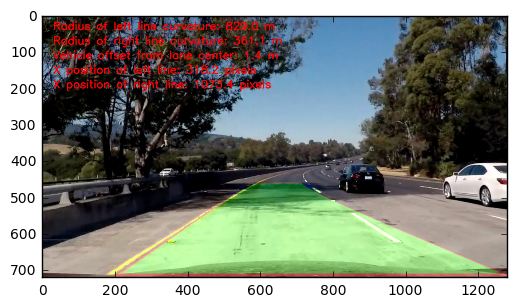

In [13]:
# . ------------------- Overlay lanes on the image ----------------
Line.FIRST_FRAME = True

final_image = process_image(img)
plt.imshow(final_image)


**Pipeline (video)**

*8. Does the pipeline established with the test images work to process the video?*

In [16]:
# . ------------------- Project Video - overlay lanes on the video frames ----------------
Line.FIRST_FRAME = True

project_output = 'p_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video p_out.mp4
[MoviePy] Writing video p_out.mp4


100%|█████████▉| 1260/1261 [11:25<00:00,  1.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p_out.mp4 



In [17]:
# . ------------------- Challenge video - overlay lanes on the video frames ----------------
Line.FIRST_FRAME = True

challenge_output = 'c_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video c_out.mp4
[MoviePy] Writing video c_out.mp4


100%|██████████| 485/485 [03:36<00:00,  2.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: c_out.mp4 

